In [11]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.transforms import Bbox
import seaborn as sns
import scanpy as sc
import scipy
import sklearn

from importlib import reload

# local imports
import utils as ut
import plotting as plt2

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/hsc_landscape.anndata.h5ad"

adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()

adata

Memory usage: current 8.89 GB, difference +8.89 GB


AnnData object with n_obs × n_vars = 54347 × 19070
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes', 'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'B_mem', 'B_naive', 'Baso', 'DC', 'Endo', 'Eos', 'Ery', 'Fibro', 'HSC', 'Macro', 'Mega', 'Mono', 'MDSC', 'Neut', 'Osteo', 'Plasma', 'pDC', 'Retic', 'Stromal', 'cluster_genes'
    uns: 'cell_type_colors', 'dataset_colors', 'go_annotations', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'organ_tissue_colors', 'panglaodb', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [3]:
pang = adata.uns['panglaodb'].copy()
pang[pang['cell_type'] == 'Hematopoietic stem cells']['gene_name'].unique()

array(['THY1', 'MPL', 'KIT', 'PROM1', 'FLT3', 'SLAMF1', 'CXCR4', 'TEK',
       'ABCB1', 'ABCG2', 'BAALC', 'SPN', 'CDCP1', 'MYADM', 'KITLG',
       'TGFB2', 'PTPRE', 'TAF7', 'GATA2', 'GPR171', 'ANGPT1', 'PROCR',
       'NFE2', 'NKX2-3', 'HHEX', 'MEIS1', 'LYL1', 'ELF1', 'HLF', 'RGS18',
       'MYCT1', 'ADGRG1', 'DNMT3B', 'MYCN', 'ARID3A', 'ITGA2B', 'GATA3',
       'ROBO4', 'PITX2', 'TXNIP', 'RUNX1', 'PTPRS', 'PTPRC', 'CD44',
       'GFI1', 'CD48', 'HMGB3', 'TLR2', 'APC', 'GNL3', 'MGST1', 'G0S2',
       'PRNP', 'CD34', 'BMI1', 'CD59', 'ITGA4', 'ANPEP', 'CD33', 'IL3RA',
       'HLX', 'NKX3-1', 'THSD1', 'NCOR2', 'EGR1', 'FGD5', 'MECOM',
       'CTNNAL1', 'VWF', 'PBX2', 'TAL1', 'ERG', 'NEO1', 'EGR3', 'MAFF',
       'ITGA6', 'GJB1', 'CDH2', 'ALDH1A1', 'GFI1B', 'NOTCH1', 'NOTCH2',
       'PLXDC2', 'ESAM', 'ACE', 'TRPC6', 'HOXB5', 'TET2'], dtype=object)

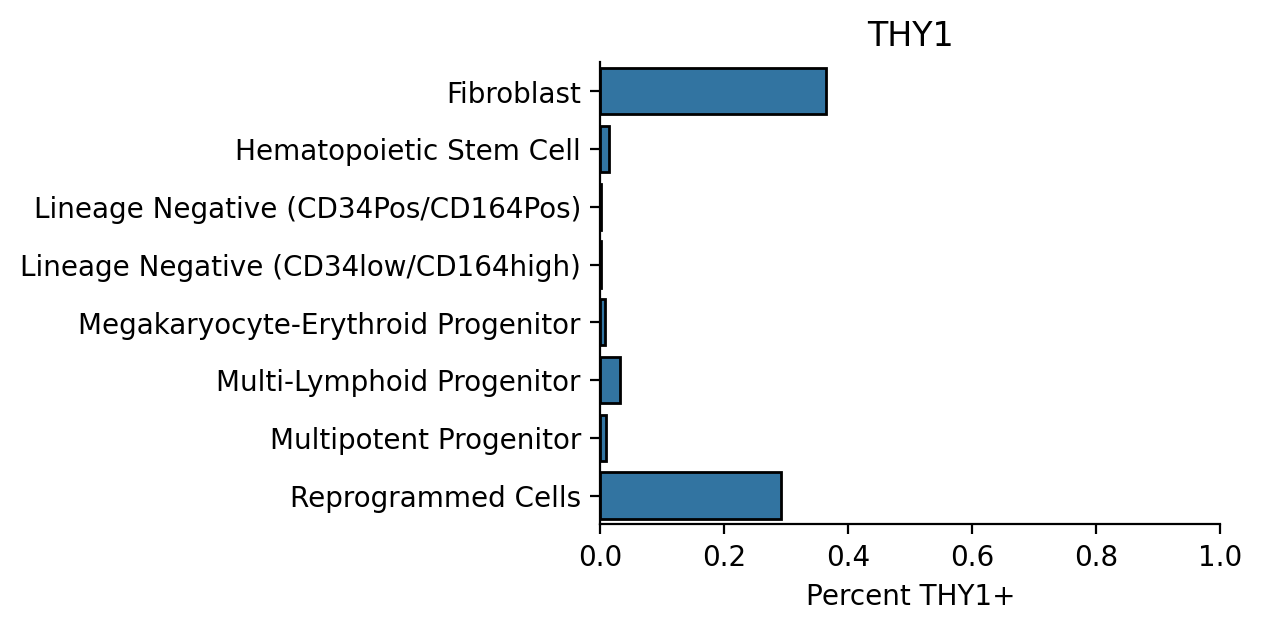

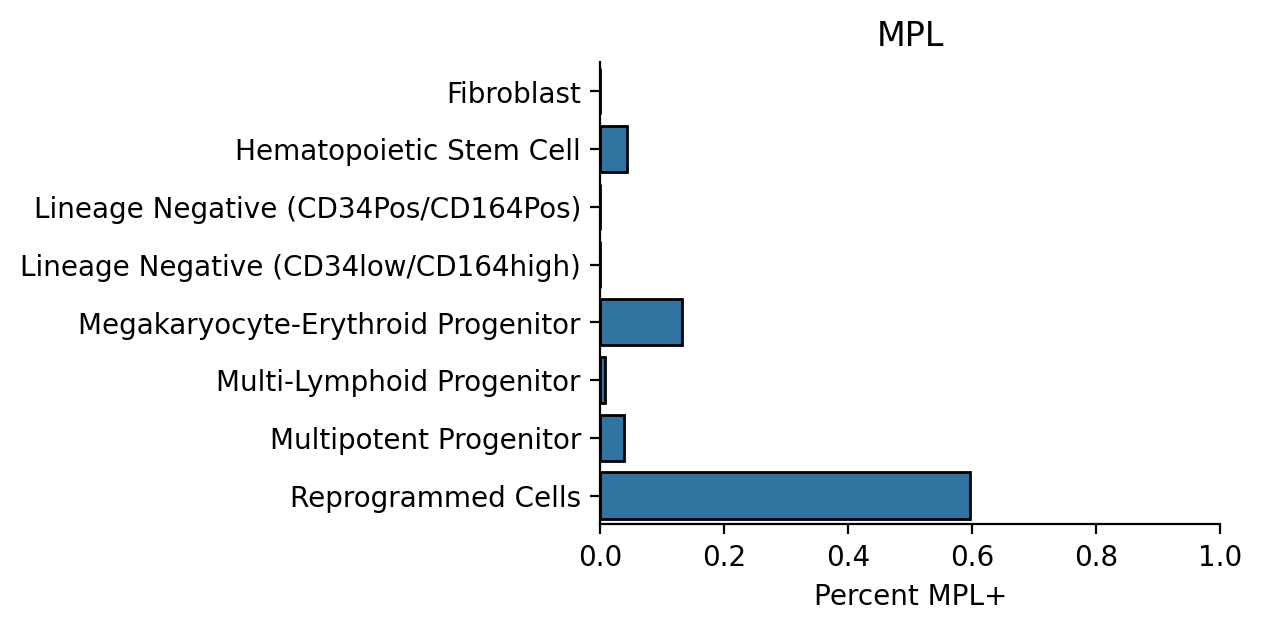

In [4]:
reload(plt2)
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

pang = adata.uns['panglaodb'].copy()
gene_list = pang[pang['cell_type'] == 'Hematopoietic stem cells']['gene_name'].unique()

for gene in gene_list[:2]:

    plt2.plot_gene_percent(
        adata, 
        gene=gene, 
        threshold=0.0,
    )

Text(0.5, 0, 'Percent GFI1B+')

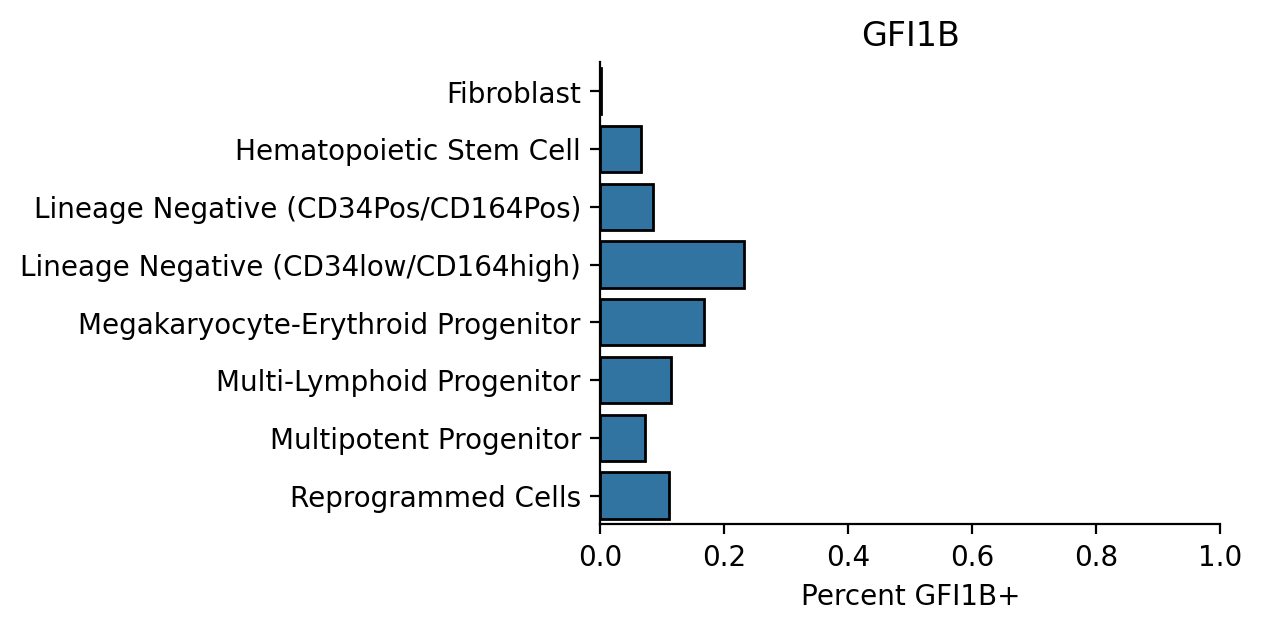

In [5]:
gene = 'GFI1B'
threshold = 0.0

pdf = adata.obs.copy()
pdf[gene] = adata[:, gene].to_df(layer='raw_counts')
pdf[gene] = np.where(pdf[gene] > threshold, 1, 0)

pdf = pdf.groupby('cell_label').agg(
    total = (gene, 'count'),
    positive = (gene, 'sum'),
)

pdf['percent'] = pdf['positive'] / pdf['total']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.barplot(
    data=pdf, 
    y='cell_label',
    x='percent',
    ec='k',
)
sns.despine()
plt.xlim([0, 1])
plt.title(gene)
plt.ylabel("")
plt.xlabel(f"Percent {gene}+")

# DEG BY CELL TYPE

In [6]:
sc.tl.rank_genes_groups(
    adata, 
    groupby="cell_label",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
    key_added='cell_type_deg',
)

deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key='cell_type_deg',
)

deg.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,Fibroblast,ZCCHC13,201.799011,-0.573340,0.0,0.0,1.0,0.559634
1,Fibroblast,LALBA,201.799011,-0.573339,0.0,0.0,1.0,0.559634
2,Fibroblast,MAGEB4,201.799011,-0.573323,0.0,0.0,1.0,0.559634
3,Fibroblast,HTR1A,201.799011,-0.573334,0.0,0.0,1.0,0.559634
4,Fibroblast,GPR50,201.799011,-0.573331,0.0,0.0,1.0,0.559634


In [7]:
alpha = 0.05
logfoldchanges = 0.0
pct_nz_group = 0.25
sig = deg.copy()
sig = deg[deg['pvals_adj'] <= alpha]
sig = sig[sig['logfoldchanges'] > logfoldchanges]
sig = sig[sig['pct_nz_group'] >= pct_nz_group]
sig.head()

for cluster, group in sig.groupby('group'):
    print(f"{cluster=}")
    group = group.sort_values(by='logfoldchanges', ascending=False)
    
    print(group[['group', 'names', 'logfoldchanges', 'pct_nz_group']].head(10))
    print()

cluster='Fibroblast'
            group   names  logfoldchanges  pct_nz_group
12898  Fibroblast   JAZF1        0.462485      0.282442
13527  Fibroblast   PNMA1        0.455060      0.267810
13510  Fibroblast  NDFIP2        0.448236      0.265516
12670  Fibroblast    YBEY        0.447218      0.287219
13222  Fibroblast   AP1S1        0.445610      0.273979
14232  Fibroblast   NUDT2        0.441851      0.252125
13433  Fibroblast   STK19        0.440431      0.272926
10508  Fibroblast  CREBL2        0.436994      0.342436
13110  Fibroblast   IFT22        0.436180      0.278718
13509  Fibroblast   USP18        0.436107      0.265629

cluster='Hematopoietic Stem Cell'
                         group      names  logfoldchanges  pct_nz_group
24886  Hematopoietic Stem Cell      OR5J2        2.635771      0.779234
38109  Hematopoietic Stem Cell      TCL1B        2.346534      0.278199
36726  Hematopoietic Stem Cell      OR1F1        2.311760      0.779234
36716  Hematopoietic Stem Cell     MAGEB

# Load marker genes

len(gene_list)=178
exp_df.shape=(62, 8)


Text(0.5, 227.44444444444437, '')

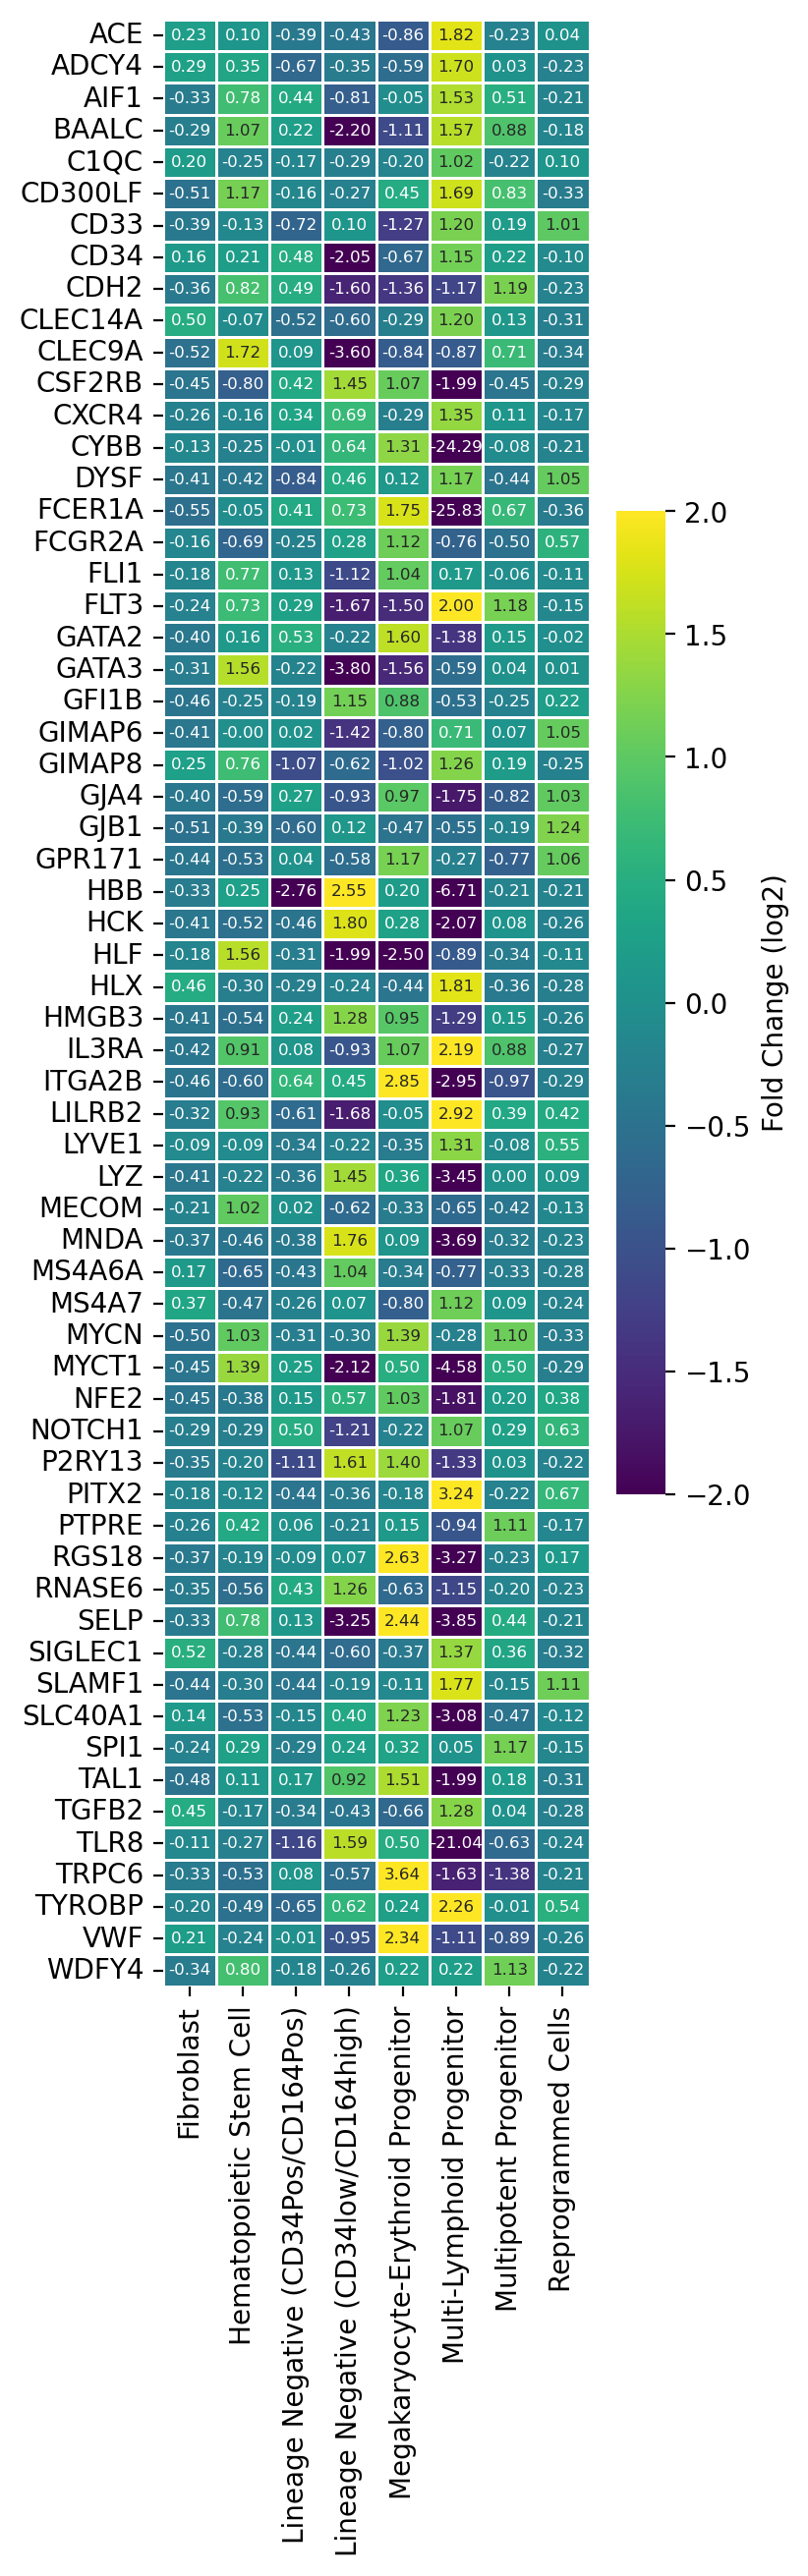

In [43]:
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
path_df = ut.load_pathway(fpath)

alpha = 0.05
logfoldchanges = 1.0
path_name = 'Hematopoietic Stem Cells'

gene_list = list(path_df[path_df[path_name]].index)
print(f"{len(gene_list)=}")

sig = deg.copy()
sig = sig[sig['pvals_adj'] <= alpha]
sig = sig[sig['logfoldchanges'] > logfoldchanges]
sig = sig[sig['names'].isin(gene_list)]

sig_gene_list = sig['names'].unique()


exp_df = pd.pivot_table(
    deg[deg['names'].isin(sig_gene_list)],
    index='group',
    columns='names',
    values='logfoldchanges',
).T

print(f"{exp_df.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 13

sns.heatmap(
    data=exp_df,
    vmax=2,
    vmin=-2,
    lw=1,
    cmap='viridis',
    annot=True,
    fmt=".2f",  # Format annotations with two decimals
    cbar_kws={'shrink' : 0.5, 'label' : 'Fold Change (log2)'},
    annot_kws={'fontsize' : 6},
)

plt.ylabel("")
plt.xlabel("")


In [50]:
exp_df['diff'] = np.abs(exp_df['Hematopoietic Stem Cell'] - exp_df['Reprogrammed Cells'])
exp_df.head(15)

group,Fibroblast,Hematopoietic Stem Cell,Lineage Negative (CD34Pos/CD164Pos),Lineage Negative (CD34low/CD164high),Megakaryocyte-Erythroid Progenitor,Multi-Lymphoid Progenitor,Multipotent Progenitor,Reprogrammed Cells,diff
names,,,,,,,,,
CXCR4,-0.264094,-0.160577,0.341068,0.688677,-0.286177,1.346755,0.105373,-0.165187,0.004610
HLX,0.457467,-0.296391,-0.285541,-0.240452,-0.442226,1.813108,-0.362042,-0.281630,0.014762
P2RY13,-0.350434,-0.204191,-1.114819,1.611138,1.398919,-1.332008,0.034615,-0.222645,0.018453
VWF,0.212635,-0.236372,-0.012855,-0.947975,2.342550,-1.108492,-0.892519,-0.264047,0.027675
TLR8,-0.113256,-0.272912,-1.155985,1.591255,0.497570,-21.039984,-0.629076,-0.243572,0.029339
CYBB,-0.130231,-0.250410,-0.007499,0.640930,1.314251,-24.287216,-0.082662,-0.209654,0.040757
SIGLEC1,0.518517,-0.276295,-0.443856,-0.604959,-0.366852,1.370895,0.358213,-0.323142,0.046847
ACE,0.233916,0.100226,-0.387557,-0.429402,-0.858664,1.818306,-0.230502,0.037627,0.062599
TGFB2,0.454402,-0.174769,-0.344237,-0.427852,-0.662751,1.279386,0.043073,-0.280271,0.105502


# Plot the results

In [ ]:
alpha = 0.05
logfoldchanges = 0.0
pct_nz_group = 0.5
sig = deg.copy()
sig = deg[deg['pvals_adj'] <= alpha]
sig = sig[sig['logfoldchanges'] > logfoldchanges

In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
gene = 'GATA2'

pdf = deg.copy()
pdf = pdf[pdf['names'] == gene]
pdf




In [ ]:
sns.barplot(
    data=pdf, 
    x='pct_nz_group',
    y='group'
)

In [ ]:
break

In [ ]:
alpha = 0.05
logfoldchanges = 0.0
pct_nz_group = 0.5
sig = deg.copy()
sig = deg[deg['pvals_adj'] <= alpha]
sig = sig[sig['logfoldchanges'] > logfoldchanges]
sig = sig[sig['pct_nz_group'] >= pct_nz_group]
sig.head()


for cluster, group in sig.groupby('group'):
    print(f"{cluster=}")
    group = group.sort_values(by='logfoldchanges', ascending=False)
    
    print(group[['group', 'names', 'logfoldchanges', 'pct_nz_group']].head(10))

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    values_to_plot="logfoldchanges", 
    cmap='bwr',
    n_genes=3,
    standard_scale='var',
    key='cell_type_deg',
    vmin=-1,
    vmax=1,
    min_logfoldchange=0.0,
)

In [ ]:
break